## CSML1010 Group3 Course_Project - Milestone 1 - Feature Engineering and Selection
#### Authors (Group3): Paul Doucet, Jerry Khidaroo
#### Project Repository: https://github.com/CSML1010-3-2020/NLPCourseProject

#### Dataset:
The dataset used in this project is the __Taskmaster-1__ dataset from Google.
[Taskmaster-1](https://research.google/tools/datasets/taskmaster-1/)

The dataset can be obtained from: https://github.com/google-research-datasets/Taskmaster

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## 1. Data Preparation

#### Load Data

In [3]:
import sqlite3

sql = """
SELECT p.*
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df = pd.read_sql_query(sql, con)

#### Get relevant columns

In [4]:
sql = """
SELECT p.selfdialog_clean, p.instruction_id
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df_all = pd.read_sql_query(sql, con)

Down sample to 1000 records.

In [5]:
print ((1000 * 1000)//7708)

129


In [6]:
# Get 50 per instruction_id then reduce to 1000
def sampling_k_elements(group, k=130):
    if len(group) < k:
        return group
    return group.sample(k)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to 1000
corpus_df = corpus_df.sample(n=1000, random_state=1)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    78
coffee-ordering-1     73
coffee-ordering-2     79
movie-finder          36
movie-tickets-1       80
movie-tickets-2       79
movie-tickets-3       76
pizza-ordering-1      70
pizza-ordering-2      81
restaurant-table-1    72
restaurant-table-2    73
restaurant-table-3    65
uber-lyft-1           71
uber-lyft-2           67
dtype: int64


#### Create Factorized 'category' column from 'Instruction_id' label column.

In [7]:
corpus_df['category'] = corpus_df['Instruction_id'].factorize()[0]
corpus_df.head(5)

,selfdialog_clean,Instruction_id,category
111,"Good morning! I need for you to please set up an appointment with a mechanic at ""Intelligent Auto Solutions"", for tomorrow morning if at all possible. Okay, so you want to be able to take it to them tomorrow morning or do you need for them to tow it from your house? Actually, if they can tow it that would be better because the breaks already locked on me once and now I'm nervous to drive it. Great, so just remind of your exact address so I can give it to them and the pick-up time so I can schedule with them. The address is 28-20 44th St. apartment 2. Should I give them your cell number or house number. Just give them my husbands number. Tell them to ask for Bill Bates at 718-204-2985 Ok, great. Let me try to schedule on another line so I can confirm with you now. Okay, and if they ask, we replaced the break pads 2 years ago. I have the assistant mechanic from the shop on the other line. I explained the problem and they need to know the exact make, model and year. Tell him it's a 2012 Toyota Camry. If he looks in his records he should see it because he's already done some work on it in the past...the carburator I think. He says he found your client record but want for you to explain when the breaks locked on you. Tell him that I was driving at around 35 mph and when I tried to stop to park the car, the breaks just wouldn't work. Thankfully, it was slightly uphill and I just put the car in neutral and it eventually stopped. I turned it off and tried the breaks again and they worked. Alright, he wants to know if they can pick it up before 8am tomorrow. Yes, that's actually the best time. Tell him to call if they're running late, please. And ask him if he can give me a price estimate. He says that he can't really confirm that it's the break pads, it might be the break fluid or a problem with the discs. Ask him to give me the worst case scenario price just to get an idea. He says that in the worst case where you need all 3 things fixed, then it would be about $500 including labor for each break. Wow! Okay, tell him I guess I have no choice. Okay, so I have a confirmed pickup with a tow truck at 28-20 44th street sometime between 7 and 8 am. Correct and that they should call if there is a problem with the tow truck. Yes, and they should call Bill Bates at 718-204-2985 with any questions. Perfect, thank you so much and see you later. Your welcome, see you in a bit.",auto-repair-appt-1,0
126,"Can you send my car to Intelligent Auto Solutions? What kind of car? 2005 Ford Focus What's wrong with it? It has a check engine light on, and I need to pass my smog test. What is your name and phone number? John Smith and 4805555555. When do you want to bring it in? Tomorrow at 8am. That works. How much will it cost? Inspection fee is $50. That works. How will you be paying? With my debit card. Okay I got you at 8am tomorrow and a fee of $50. Yes, thanks. Thanks for your business. Bye. Bye.",auto-repair-appt-1,0
555,"hey frank its me jake. Hey mr jake what can i do for you? so i want to go see a movie and i was wondering if you could book me a ticket through fandango? oh yeah of course i can. what theater? Regal Cinemas Jack London 9 is that 100 Washington St, Oakland? yes thats it. ok and what movie and what time of day? Happy Death Day 2U and sometime later tonight. ok Happy Death Day 2U has a 9:30pm is that ok? yes. are there any 3d showing and if so how much more a ticket are they? there is one at 11:00pm and it is 16.95 for an adult. ah that will be too late so lets do the 9:30 showing. ok and how many tickets? I will need 2 one for myself and one for sam. ok so i have 2 tickets for 2 adults yourself and sam at the 930 showing of Happy Death Day 2U is that correct? yes it is. oh how much is the pice per ticket? the price of a adult ticket is 10.95$. ok i was just wondering.can you send the ticket to me in a text? absolutly already on top of it. anything else i can do for you? no that shoud do

#### Word Embeddings

In [8]:
df.columns

Index(['index', 'id', 'Conversation', 'Instruction_id', 'service_type',
       'selfdialog_clean', 'selfdialog_lemma', 'selfdialog_nouns',
       'selfdialog_adjectives', 'selfdialog_verbs', 'selfdialog_nav',
       'no_tokens'],
      dtype='object')

In [9]:
corpus_df.columns

Index(['selfdialog_clean', 'Instruction_id', 'category'], dtype='object')

#### Do Some Additional CLeaning

In [10]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = "'" + doc + "'"
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = [[word.lower() for word in sent if word not in remove_terms] for sent in doc]
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [11]:
for i, row in corpus_df.iterrows():
    corpus_df.at[i, "selfdialog_norm"] = normalize_corpus(row.selfdialog_clean) 

corpus_df.head(3)

,selfdialog_clean,Instruction_id,category,selfdialog_norm
111,"Good morning! I need for you to please set up an appointment with a mechanic at ""Intelligent Auto Solutions"", for tomorrow morning if at all possible. Okay, so you want to be able to take it to them tomorrow morning or do you need for them to tow it from your house? Actually, if they can tow it that would be better because the breaks already locked on me once and now I'm nervous to drive it. Great, so just remind of your exact address so I can give it to them and the pick-up time so I can schedule with them. The address is 28-20 44th St. apartment 2. Should I give them your cell number or house number. Just give them my husbands number. Tell them to ask for Bill Bates at 718-204-2985 Ok, great. Let me try to schedule on another line so I can confirm with you now. Okay, and if they ask, we replaced the break pads 2 years ago. I have the assistant mechanic from the shop on the other line. I explained the problem and they need to know the exact make, model and year. Tell him it's a 2012 Toyota Camry. If he looks in his records he should see it because he's already done some work on it in the past...the carburator I think. He says he found your client record but want for you to explain when the breaks locked on you. Tell him that I was driving at around 35 mph and when I tried to stop to park the car, the breaks just wouldn't work. Thankfully, it was slightly uphill and I just put the car in neutral and it eventually stopped. I turned it off and tried the breaks again and they worked. Alright, he wants to know if they can pick it up before 8am tomorrow. Yes, that's actually the best time. Tell him to call if they're running late, please. And ask him if he can give me a price estimate. He says that he can't really confirm that it's the break pads, it might be the break fluid or a problem with the discs. Ask him to give me the worst case scenario price just to get an idea. He says that in the worst case where you need all 3 things fixed, then it would be about $500 including labor for each break. Wow! Okay, tell him I guess I have no choice. Okay, so I have a confirmed pickup with a tow truck at 28-20 44th street sometime between 7 and 8 am. Correct and that they should call if there is a problem with the tow truck. Yes, and they should call Bill Bates at 718-204-2985 with any questions. Perfect, thank you so much and see you later. Your welcome, see you in a bit.",auto-repair-appt-1,0,good morning need please set appointment mechanic intelligent auto solutions tomorrow morning possible okay want able take tomorrow morning need tow house actually tow would better breaks already locked im nervous drive great remind exact address give pickup time schedule address th st apartment give cell number house number give husbands number tell ask bill bates ok great let try schedule another line confirm okay ask replaced break pads years ago assistant mechanic shop line explained problem need know exact make model year tell toyota camry looks records see hes already done work pastthe carburator think says found client record want explain breaks locked tell driving around mph tried stop park car breaks wouldnt work thankfully slightly uphill put car neutral eventually stopped turned tried breaks worked alright wants know pick tomorrow yes thats actually best time tell call theyre running late please ask give price estimate says cant really confirm break pads might break fluid problem discs ask give worst case scenario price get idea says worst case need things fixed would including labor break wow okay tell guess choice okay confirmed pickup tow truck th street sometime correct call problem tow truck yes call bill bates questions perfect thank much see later welcome see bit
126,"Can you send my car to Intelligent Auto Solutions? What kind of car? 2005 Ford Focus What's wrong with it? It has a check engine light on, and I need to pass my smog test. What is your name and phone numbe

In [12]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm.tolist())

print(len(doc_lst))
doc_lst[1:5]

1000


['send car intelligent auto solutions kind car ford focus whats wrong check engine light need pass smog test name phone number john smith want bring tomorrow works much cost inspection fee works paying debit card okay got tomorrow fee yes thanks thanks business bye bye',
 'hey frank jake hey mr jake want go see movie wondering could book ticket fandango oh yeah course theater regal cinemas jack london washington st oakland yes thats ok movie time day happy death day u sometime later tonight ok happy death day u pm ok yes showing much ticket one pm adult ah late lets showing ok many tickets need one one sam ok tickets adults sam showing happy death day u correct yes oh much pice per ticket price adult ticket ok wonderingcan send ticket text absolutly already top anything else shoud thank frank welcome mr jake',
 'hi give hand booking dinner reservations tonight sure thinking thinking bookbinders moshulu prefer think bookbinders little bit better personally okay lets try sounds good time

#### Build Vocabulary

In [13]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(doc_lst)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
Vocabulary Size: 5860
Vocabulary Sample: [('like', 1), ('would', 2), ('ok', 3), ('okay', 4), ('yes', 5), ('pm', 6), ('want', 7), ('order', 8), ('thank', 9), ('please', 10)]


#### Build (context_words, target_word) pair generator

In [14]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [15]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['good', 'morning', 'please', 'set'] -> Target (Y): need
Context (X): ['morning', 'need', 'set', 'appointment'] -> Target (Y): please
Context (X): ['need', 'please', 'appointment', 'mechanic'] -> Target (Y): set
Context (X): ['please', 'set', 'mechanic', 'intelligent'] -> Target (Y): appointment
Context (X): ['set', 'appointment', 'intelligent', 'auto'] -> Target (Y): mechanic
Context (X): ['appointment', 'mechanic', 'auto', 'solutions'] -> Target (Y): intelligent
Context (X): ['mechanic', 'intelligent', 'solutions', 'tomorrow'] -> Target (Y): auto
Context (X): ['intelligent', 'auto', 'tomorrow', 'morning'] -> Target (Y): solutions
Context (X): ['auto', 'solutions', 'morning', 'possible'] -> Target (Y): tomorrow
Context (X): ['solutions', 'tomorrow', 'possible', 'okay'] -> Target (Y): morning
Context (X): ['tomorrow', 'morning', 'okay', 'want'] -> Target (Y): possible


#### Set up Dictionaries to Cross-Refrence 'Instruction_id' and its Factorized value 'category'

In [16]:
category_id_df = corpus_df[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category', 'Instruction_id']].values)

#### Split Data into Train and Test Sets

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['Instruction_id'], test_size=0.25, random_state = 0)

## Bag of Words Feature Extraction

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(doc_lst)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 1, 0],
       [0, 6, 5, ..., 0, 0, 1]], dtype=int64)

In [19]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,ok,okay,yes,pm,want,order,thank,please,time,tickets,one,great,...,sparkling,ned,mainly,stocked,liquors,thrilled,daily,literally,sand,crenshaw,actaully,gota,pls,texing,anyhow
0,0,0,2,1,4,2,0,2,0,1,2,2,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,6,0,3,2,1,0,1,0,1,2,3,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,4,0,0,0,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,2,3,0,9,5,0,0,3,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,8,8,0,0,2,0,0,1,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,6,5,3,0,6,1,0,0,1,1,0,0,0,1,...,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0
997,0,1,1,0,9,2,0,0,0,1,0,1,0,2,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
998,0,1,1,1,0,3,4,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0


In [20]:
# Get BOW features
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(750, 5860)
(250, 5860)
(250,)


#### Define Model Builder Function

In [21]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)

    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()

    return cm, pred, f1, report, accuracy

## Bag of Words Feature Benchmarking Baseline with Naive Bayes Classifier

In [22]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
cm_nb_bow, pred_nb_bow, f1_nb_bow, report_nb_bow, accuracy_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [23]:
# Save benchmark output
rows_benchmarks = []
rows_benchmarks.append(["BOW Naive Bayes All Features", f1_nb_bow, accuracy_nb_bow])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.68,0.70


In [24]:
from sklearn.metrics import confusion_matrix

cm_nb_bow

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 16,  8,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2, 11,  1,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  2,  3, 23,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  9,  8,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  1,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 13, 16,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  8]],
      dtype=int64)

In [25]:
from sklearn import metrics

print("Label" + report_nb_bow)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       1.00      0.26      0.42        19
 coffee-ordering-2       0.53      1.00      0.70        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.64      0.80      0.71        20
   movie-tickets-2       0.73      0.50      0.59        22
   movie-tickets-3       0.82      0.96      0.88        24
  pizza-ordering-1       0.53      0.64      0.58        14
  pizza-ordering-2       0.75      0.65      0.70        23
restaurant-table-1       0.75      0.41      0.53        22
restaurant-table-2       0.50      0.94      0.65        17
restaurant-table-3       1.00      0.69      0.81        16
       uber-lyft-1       0.58      0.47      0.52        15
       uber-lyft-2       0.53      0.62      0.57        13

          accuracy                           0.70       250
         macro avg       0.74    

## Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Function

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test):
    X_norm = MinMaxScaler().fit_transform(features_train, labels_train)
    #X_norm = MinMaxScaler(feature_range=(0,1), copy=True).fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()

    return cm_chi, predict_chi, f1_chi, report_chi, accuracy_chi

#### Iterate through number of features and get benchmark results

In [27]:
rows = []
for i in range(250, 5740, 10): # range(a, b, c) will count from a to b by intervals of c.
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


#### Plot f1-score by number of selected features

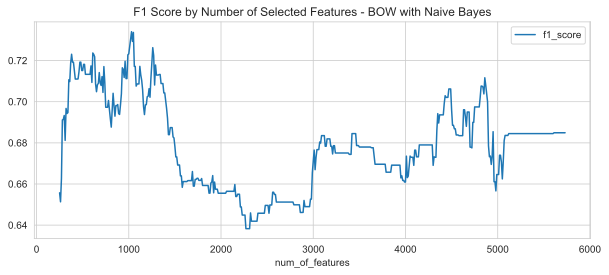

In [28]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [29]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

980 1080 1


,num_of_features,f1_score,accuracy
78,1030,0.73,0.74
80,1050,0.73,0.74
77,1020,0.73,0.73
79,1040,0.73,0.73
76,1010,0.73,0.73


#### Get a more fine-grained look at the optimal number of features region

In [30]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

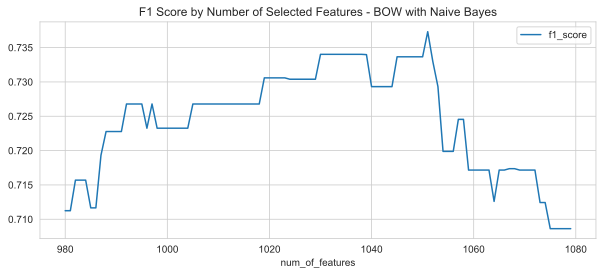

In [31]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [32]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

1051


,num_of_features,f1_score,accuracy
71,1051,0.74,0.74
50,1030,0.73,0.74
58,1038,0.73,0.74
51,1031,0.73,0.74
52,1032,0.73,0.74


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [33]:
model_nb_bow_opt = MultinomialNB()
cm_opt_bow, pred_opt_bow, f1_opt_bow, report_opt_bow, accuracy_opt_bow = SelectBestModelFeatures_Chi(model_nb_bow_opt, Opt_no_of_feat, X_train_bow, y_train, X_test_bow, y_test)

In [34]:
print(cm_opt_bow)

[[18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  8  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11 13  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  4 16  1  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  2 23  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  9  6  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5 17  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 11  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 10 16  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  1 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 11  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  3  8]]


In [35]:
print("Label" + report_opt_bow)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.73      0.42      0.53        19
 coffee-ordering-2       0.54      0.81      0.65        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.79      0.75      0.77        20
   movie-tickets-2       0.70      0.73      0.71        22
   movie-tickets-3       0.88      0.96      0.92        24
  pizza-ordering-1       0.60      0.64      0.62        14
  pizza-ordering-2       0.77      0.74      0.76        23
restaurant-table-1       0.85      0.50      0.63        22
restaurant-table-2       0.53      0.94      0.68        17
restaurant-table-3       0.83      0.62      0.71        16
       uber-lyft-1       0.69      0.73      0.71        15
       uber-lyft-2       0.73      0.62      0.67        13

          accuracy                           0.74       250
         macro avg       0.76    

In [36]:
# Save benchmark output
rows_benchmarks.append(["BOW Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_opt_bow, accuracy_opt_bow])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.68,0.70
1,BOW Naive Bayes Optimal Features Selected: 1051,0.74,0.74


## Bag of N-Grams Feature Extraction

In [156]:
from sklearn.feature_extraction.text import CountVectorizer

bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(X_train)
bv_matrix = bv_matrix.toarray()
bv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [157]:
# get all unique words in the corpus
vocab = bv.get_feature_names()
# show document feature vectors
pd.DataFrame(bv_matrix, columns=vocab)

,aa target,aab india,abc see,abc thanks,abgout second,ability scan,able able,able access,able accomadate,able accommodate,able apply,able attend,able bring,able check,able email,...,yyy thank,za great,za ok,za please,za ready,za would,zero ok,zing like,zios near,zios pm,zios yes,zip code,ziti available,zoo kuhio,zoo right
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
746,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
747,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
748,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [158]:
# Get Bag of N-Gram features
X_train_bong = bv.fit_transform(X_train).toarray()
X_test_bong = bv.transform(X_test).toarray()
print (X_train_bong.shape) 
print (X_test_bong.shape) 
print (y_test.shape)

(750, 37148)
(250, 37148)
(250,)


## Bag of N-Grams Feature Benchmarking with Naive Bayes Classifier

In [159]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bong = MultinomialNB()
cm_nb_bong, pred_nb_bong, f1_nb_bong, report_nb_bong, accuracy_nb_bong = Build_Model(model_nb_bong, X_train_bong, y_train, X_test_bong, y_test)

In [160]:
# Save benchmark output
rows_benchmarks.append(["Bag of N-Gram Naive Bayes All Features", f1_nb_bong, accuracy_nb_bong])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.68,0.70
1,BOW Naive Bayes Optimal Features Selected: 1051,0.74,0.74
2,Bag of N-Gram Naive Bayes All Features,0.66,0.66
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,TF-IDF Naive Bayes All Features,0.54,0.60
5,TF-IDF Naive Bayes Optimal Features Selected: 330,0.58,0.62
6,Word2Vec Naive Bayes All Features,0.72,0.72
7,Word2Vec Naive Bayes Optimal Features Selected: 72,0.73,0.73
8,Word2Vec Fastext Naive Bayes All Features,0.56,0.60
9,Word2Vec from Fastest Naive Bayes Optimal Features Selected: 72,0.58,0.61


In [42]:
from sklearn.metrics import confusion_matrix

cm_nb_bong

array([[17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  5,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14, 14,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2, 17,  9,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  3, 12,  3,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  1, 21,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8, 11,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5, 11,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  8,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  9, 16,  7,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  5,  0,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 12]],
      dtype=int64)

In [43]:
from sklearn import metrics

print(report_nb_bong)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      0.94      0.97        18
 coffee-ordering-1       0.71      0.26      0.38        19
 coffee-ordering-2       0.47      0.88      0.61        16
      movie-finder       1.00      0.64      0.78        11
   movie-tickets-1       0.61      0.85      0.71        20
   movie-tickets-2       0.60      0.55      0.57        22
   movie-tickets-3       0.95      0.88      0.91        24
  pizza-ordering-1       0.42      0.57      0.48        14
  pizza-ordering-2       0.69      0.48      0.56        23
restaurant-table-1       0.80      0.36      0.50        22
restaurant-table-2       0.50      0.94      0.65        17
restaurant-table-3       0.60      0.56      0.58        16
       uber-lyft-1       0.90      0.60      0.72        15
       uber-lyft-2       0.71      0.92      0.80        13

          accuracy                           0.66       250
         macro avg       0.71      0.67      0.66       25

## Feature Selection: Bag of N-Gram Features with Naive Bayes Model Using Chi-Squared Selector

#### Iterate through number of features and get benchmark results

In [44]:
rows = []
for i in range(250, 5740, 10): # range(a, b, c) will count from a to b by intervals of c.
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

#### Plot f1-score by number of selected features

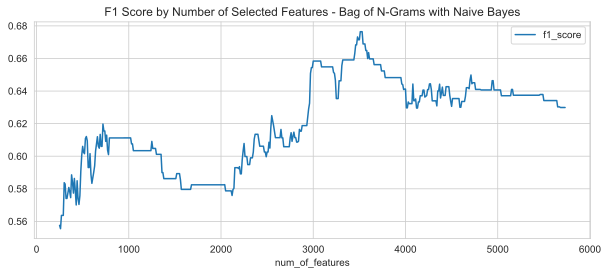

In [45]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [46]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

3470 3570 1


,num_of_features,f1_score,accuracy
327,3520,0.68,0.68
326,3510,0.68,0.68
328,3530,0.68,0.68
323,3480,0.67,0.68
324,3490,0.67,0.68


#### Get a more fine-grained look at the optimal number of features region

In [47]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

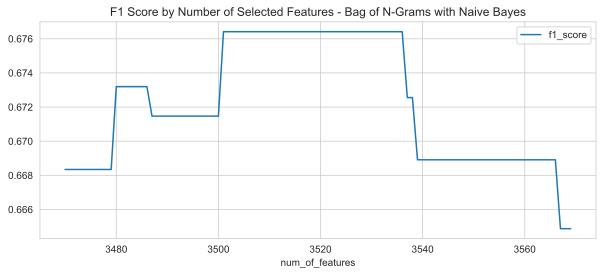

In [48]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [49]:
acc_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
50,3520,0.68,0.68
51,3521,0.68,0.68
35,3505,0.68,0.68
36,3506,0.68,0.68
37,3507,0.68,0.68


## Benchmark Bag of N-Grams With Optimal Features Selected using Naive Bayes Model

In [50]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat

3520

In [51]:
model_nb_bong_opt = MultinomialNB()
cm_optimal, pred_opt, f1_opt, report_opt, accuracy_opt = SelectBestModelFeatures_Chi(model_nb_bong_opt, Opt_no_of_feat, X_train_bong, y_train, X_test_bong, y_test)

In [52]:
print(report_opt)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      0.94      0.97        18
 coffee-ordering-1       0.75      0.32      0.44        19
 coffee-ordering-2       0.52      0.88      0.65        16
      movie-finder       1.00      0.82      0.90        11
   movie-tickets-1       0.70      0.80      0.74        20
   movie-tickets-2       0.56      0.64      0.60        22
   movie-tickets-3       0.86      0.75      0.80        24
  pizza-ordering-1       0.47      0.57      0.52        14
  pizza-ordering-2       0.70      0.61      0.65        23
restaurant-table-1       0.75      0.41      0.53        22
restaurant-table-2       0.57      1.00      0.72        17
restaurant-table-3       0.67      0.62      0.65        16
       uber-lyft-1       0.88      0.47      0.61        15
       uber-lyft-2       0.67      0.92      0.77        13

          accuracy                           0.68       250
         macro avg       0.72      0.70      0.68       25

In [53]:
# Save benchmark output
rows_benchmarks.append(["Bag of N-Gram Naive Bayes Optimal Features Selected: 960", f1_opt, accuracy_opt])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.68,0.70
1,BOW Naive Bayes Optimal Features Selected: 1051,0.74,0.74
2,Bag of N-Gram Naive Bayes All Features,0.66,0.66
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68


## TF-IDF Feature Extraction

In [54]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
#vocab_tfidf = count_vect.vocabulary_
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(750, 5074)
(250, 5074)


## TF-IDF Baseline Benchmarking with Naive Bayes Classifier: Multinomial variant

In [55]:
clf = MultinomialNB()#.fit(X_train_tfidf, y_train)

cm_nb_tfidf, pred_nb_tfidf, f1_nb_tfidf, report_nb_tfidf, accuracy_nb_tfidf = Build_Model(clf, X_train_tfidf, y_train, X_test_tfidf, y_test)

#### Make Some Predictions

In [56]:
X_new_data_counts = count_vect.transform(["appointment online car checking bmw okay hold minute problem okay entered thank need bring need alignment"])
X_new_data_tfidf = tfidf_transformer.fit_transform(X_new_data_counts)
print(X_new_data_tfidf.shape)
y_pred_new = clf.predict(X_new_data_tfidf)
y_pred_new

(1, 5074)


array(['auto-repair-appt-1'], dtype='<U18')

#### Metrics for TF-IDF with Naive Bayes Classifier: Multinomial variant

In [57]:
from sklearn.metrics import confusion_matrix

cm_nb_tfidf

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 19, 16,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  4, 17, 10,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  4,  3, 12,  4,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  2,  0,  0, 19,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  5,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6, 18,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 22, 17,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  8]],
      dtype=int64)

In [58]:
from sklearn import metrics

print("Label" + report_nb_tfidf)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.00      0.00      0.00        19
 coffee-ordering-2       0.44      1.00      0.62        16
      movie-finder       0.00      0.00      0.00        11
   movie-tickets-1       0.53      0.85      0.65        20
   movie-tickets-2       0.50      0.55      0.52        22
   movie-tickets-3       0.90      0.79      0.84        24
  pizza-ordering-1       0.62      0.57      0.59        14
  pizza-ordering-2       0.75      0.78      0.77        23
restaurant-table-1       0.00      0.00      0.00        22
restaurant-table-2       0.35      1.00      0.52        17
restaurant-table-3       1.00      0.44      0.61        16
       uber-lyft-1       0.64      0.60      0.62        15
       uber-lyft-2       0.62      0.62      0.62        13

          accuracy                           0.60       250
         macro avg       0.53    

In [59]:
# Save benchmark output
rows_benchmarks.append(["TF-IDF Naive Bayes All Features", f1_nb_tfidf, accuracy_nb_tfidf])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.68,0.70
1,BOW Naive Bayes Optimal Features Selected: 1051,0.74,0.74
2,Bag of N-Gram Naive Bayes All Features,0.66,0.66
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,TF-IDF Naive Bayes All Features,0.54,0.60


In [60]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

def SelectBestModelFeatures_Chi_sparse(model, num_feats, features_train, labels_train, features_test, labels_test):
    X_norm = MaxAbsScaler().fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()

    return cm_chi, predict_chi, f1_chi, report_chi, accuracy_chi

## Feature Selection - TF-IDF with Naive Bayes

In [61]:
rows = []
for i in range(50, 4850, 100): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi_sparse(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

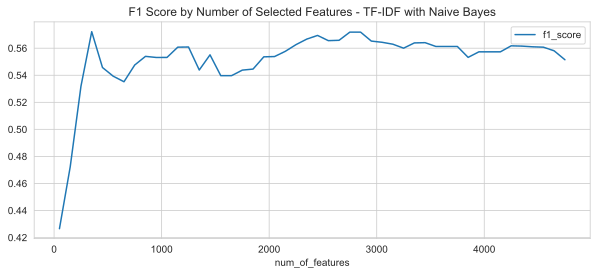

In [62]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [63]:
Opt_no_of_feat = int(sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

300 400 1


,num_of_features,f1_score,accuracy
3,350,0.57,0.62
28,2850,0.57,0.62
27,2750,0.57,0.62
24,2450,0.57,0.62
23,2350,0.57,0.61


#### Take closer look at region around optimal features

In [64]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi_sparse(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

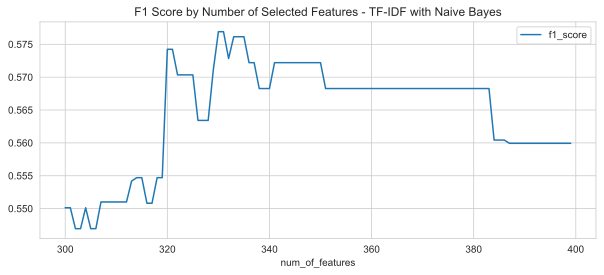

In [65]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [66]:
Opt_no_of_feat = int(sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
30,330,0.58,0.62
31,331,0.58,0.62
33,333,0.58,0.62
34,334,0.58,0.62
35,335,0.58,0.62


## Benchmark TF-IDF Features with Naive Bayes on Optimal Features

In [67]:
cm_tf_nb, pred_tf_nb, f1_tf_nb, report_tf_nb, accuracy_tf_nb = SelectBestModelFeatures_Chi_sparse(clf, Opt_no_of_feat, X_train_tfidf, y_train, X_test_tfidf, y_test)
# Save benchmark output
rows_benchmarks.append(["TF-IDF Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_tf_nb, accuracy_tf_nb])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.68,0.70
1,BOW Naive Bayes Optimal Features Selected: 1051,0.74,0.74
2,Bag of N-Gram Naive Bayes All Features,0.66,0.66
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,TF-IDF Naive Bayes All Features,0.54,0.60
5,TF-IDF Naive Bayes Optimal Features Selected: 330,0.58,0.62


#### Metrics For Each Class

In [68]:
from sklearn import metrics
print("Label" + report_tf_nb)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       1.00      0.05      0.10        19
 coffee-ordering-2       0.47      1.00      0.64        16
      movie-finder       1.00      0.36      0.53        11
   movie-tickets-1       0.64      0.80      0.71        20
   movie-tickets-2       0.57      0.77      0.65        22
   movie-tickets-3       0.89      0.71      0.79        24
  pizza-ordering-1       0.61      0.79      0.69        14
  pizza-ordering-2       0.84      0.70      0.76        23
restaurant-table-1       0.50      0.05      0.08        22
restaurant-table-2       0.33      1.00      0.50        17
restaurant-table-3       0.50      0.06      0.11        16
       uber-lyft-1       0.79      0.73      0.76        15
       uber-lyft-2       0.77      0.77      0.77        13

          accuracy                           0.62       250
         macro avg       0.71    

## Word2Vec Feature Extraction

In [69]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['pizza', 'terminator', 'star', 'east', 'korean','playing']}
similar_words

{'pizza': ['toppings', 'dominos', 'large', 'meat', 'sides'],
 'terminator': ['abyss', 'judgment', 'avatar', 'sigourney', 'cameron'],
 'star': ['wars', 'jedi', 'series', 'rouge', 'blade'],
 'east': ['th', 'forever', 'west', 'superior', 'fire'],
 'korean': ['lauderhill', 'bbq', 'bbgo', 'pig', 'manna'],
 'playing': ['pet', 'vogue', 'theatres', 'ocala', 'shrek']}

#### Visualizing word embeddings

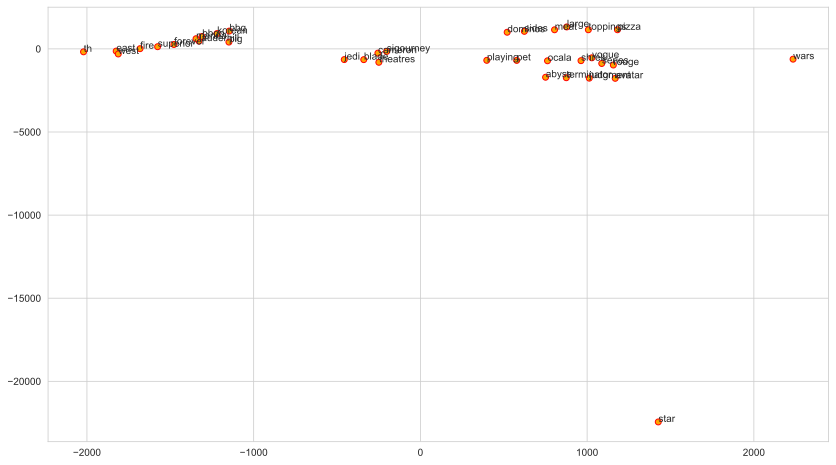

In [70]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Applying the word2vec model on our Train dataset

In [71]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in X_test]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

In [72]:
def Get_W2V_Model(feat_size):
    w2v_mod = word2vec.Word2Vec(tokenized_corpus, size=feat_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)
    return w2v_mod

#### Do a Word Test

In [73]:
w2v_model.wv['jedi']

array([-0.06716795, -0.668418  , -0.16846125,  0.5654192 , -0.7998891 ,
       -0.18393044,  1.1595312 , -1.1167941 , -0.2581987 ,  0.08313894,
       -0.2738338 , -0.3527476 ,  0.64471555, -0.34533215, -0.12732938,
       -0.6345317 ,  0.03827124, -0.90778697, -0.02815883, -0.31553942,
       -0.00919804, -0.2619103 ,  0.19886205,  0.01101353, -0.4202764 ,
        0.07455195, -0.16239998, -0.06440642,  0.32385778,  0.03882569,
        0.11968738,  0.41252467,  0.20370822, -0.06422635,  0.20260346,
        0.08647044, -0.00758478,  0.24468006, -0.08499359, -0.26831463,
        0.47294587, -0.08536024, -0.24050264, -0.27262336,  0.17404325,
        0.3521133 , -0.20155933,  0.01632622, -0.43716162,  0.15122922,
       -0.8844197 , -0.42766562,  0.16036178, -0.38131753, -0.38049307,
       -0.14297828, -0.16374111, -0.16225791,  0.06266   , -0.06307597,
        0.7807302 ,  0.17624073, -0.59021485, -0.3431579 , -0.145625  ,
        0.01950651,  0.41401058,  0.62343985,  0.22729045, -0.59

#### Build framework for getting document level embeddings

In [74]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [75]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.06,0.63,-0.37,-0.28,0.96,-0.57,-1.15,0.87,1.05,-0.04,0.42,-0.13,-0.91,0.62,1.23,...,0.11,0.54,0.06,-0.11,0.53,0.13,-0.63,0.60,0.01,-0.61,0.48,-0.57,1.60,0.37,-0.24
1,0.30,0.81,0.03,-0.37,0.40,0.67,0.98,-0.40,-0.44,0.78,-0.04,-0.24,1.55,-0.15,0.03,...,0.40,-0.25,0.00,0.75,0.23,0.24,0.29,-0.14,0.35,0.18,-0.42,0.64,-1.33,0.25,0.75
2,0.47,-0.70,-0.22,-0.32,0.75,0.12,-0.31,0.38,0.73,0.72,-0.02,0.11,-0.32,0.13,0.77,...,-0.52,-0.19,-0.58,0.91,0.06,0.94,-0.15,-0.83,0.41,-0.03,-0.26,0.57,-0.28,-0.06,0.65
3,-0.51,0.63,0.02,0.18,1.23,-1.28,0.18,-0.01,0.22,0.43,0.52,-0.08,0.33,0.58,-0.20,...,-0.91,0.14,0.21,-0.23,-0.48,0.78,0.25,0.17,0.86,-0.77,0.12,-0.56,0.12,0.80,0.44
4,0.47,-0.28,-0.77,0.11,1.09,-0.42,-0.74,0.13,0.10,-0.25,0.14,-0.58,-0.45,0.29,-0.10,...,-0.82,0.13,-0.58,0.13,-0.15,0.73,0.78,-0.77,0.21,-0.38,-0.50,-0.04,-0.48,0.62,-0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.22,-0.53,-0.02,-0.84,0.75,-0.10,-0.09,0.42,0.75,0.77,-0.05,0.05,-0.27,-0.28,0.95,...,-0.55,-0.97,-1.11,0.82,0.29,1.15,-0.45,-0.50,1.02,-0.41,-0.13,0.51,0.07,-0.19,0.35
746,-0.27,0.49,0.53,-0.05,0.66,-0.36,-0.31,0.10,0.99,-0.21,0.26,0.07,0.45,0.25,-0.09,...,-0.90,-0.26,-0.52,0.39,-0.58,-0.12,0.26,0.22,0.22,-0.34,-0.50,0.26,-0.39,0.85,0.10
747,0.38,0.03,0.09,-0.97,1.29,0.14,-0.44,0.31,0.40,0.98,-0.16,-0.02,0.28,0.30,0.02,...,-0.69,-0.29,-0.25,1.09,0.29,1.24,-0.31,-0.87,0.52,-0.32,-0.22,0.42,-0.61,-0.32,0.74
748,-0.11,0.40,-0.85,-0.70,0.70,-1.23,-0.41,0.07,0.57,-0.05,-0.00,-0.84,-0.25,0.45,-0.30,...,-0.45,0.05,-0.31,0.65,0.21,0.48,-0.01,-0.63,0.98,-0.67,-0.20,-0.30,0.10,0.77,-0.55


In [76]:
w2v_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model,
                                             num_features=feature_size)
                                             
print(w2v_test_array.shape)

(250, 100)


## Word2vec Feature Benchmarking with Naive Bayes Classifier

In [77]:
from sklearn.naive_bayes import GaussianNB

#model_w2v_nb = MultinomialNB()
model_w2v_nb = GaussianNB()
cm_nb_w2v, pred_nb_w2v, f1_nb_w2v, report_nb_w2v, accuracy_nb_w2v  = SelectBestModelFeatures_Chi(model_w2v_nb, 100, w2v_feature_array, y_train, w2v_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Naive Bayes All Features", f1_nb_w2v, accuracy_nb_w2v])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.68,0.70
1,BOW Naive Bayes Optimal Features Selected: 1051,0.74,0.74
2,Bag of N-Gram Naive Bayes All Features,0.66,0.66
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,TF-IDF Naive Bayes All Features,0.54,0.60
5,TF-IDF Naive Bayes Optimal Features Selected: 330,0.58,0.62
6,Word2Vec Naive Bayes All Features,0.72,0.72


In [78]:
cm_nb_w2v

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 16,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  3, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 13,  7,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  4,  9,  1,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  2,  6, 22,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10, 10,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  4, 13,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 13,  1,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 13,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  3, 13,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 11]],
      dtype=int64)

In [79]:
print("Label" + report_nb_w2v)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.73      0.84      0.78        19
 coffee-ordering-2       0.77      0.62      0.69        16
      movie-finder       0.91      0.91      0.91        11
   movie-tickets-1       0.59      0.65      0.62        20
   movie-tickets-2       0.60      0.41      0.49        22
   movie-tickets-3       0.73      0.92      0.81        24
  pizza-ordering-1       0.50      0.71      0.59        14
  pizza-ordering-2       0.76      0.57      0.65        23
restaurant-table-1       0.81      0.59      0.68        22
restaurant-table-2       0.59      0.76      0.67        17
restaurant-table-3       0.76      0.81      0.79        16
       uber-lyft-1       0.83      0.67      0.74        15
       uber-lyft-2       0.73      0.85      0.79        13

          accuracy                           0.72       250
         macro avg       0.74    

## Feature Selection - Word2Vec Features with Naive Bayes Model

In [80]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_w2v_nb, i, w2v_feature_array, y_train, w2v_test_array, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_w2v_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

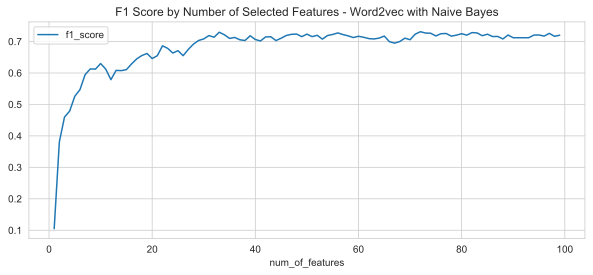

In [81]:
sel_nb_w2v_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec with Naive Bayes", figsize=(10, 4))

In [82]:
Opt_no_of_feat = int(sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
71,72,0.73,0.73
32,33,0.73,0.73
81,82,0.73,0.73
55,56,0.73,0.73
82,83,0.73,0.73


In [83]:
cm_nb_w2v, pred_nb_w2v, f1_nb_w2v, report_nb_w2v, accuracy_nb_w2v  = SelectBestModelFeatures_Chi(model_w2v_nb, Opt_no_of_feat, w2v_feature_array, y_train, w2v_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_nb_w2v, accuracy_nb_w2v])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.68,0.70
1,BOW Naive Bayes Optimal Features Selected: 1051,0.74,0.74
2,Bag of N-Gram Naive Bayes All Features,0.66,0.66
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,TF-IDF Naive Bayes All Features,0.54,0.60
5,TF-IDF Naive Bayes Optimal Features Selected: 330,0.58,0.62
6,Word2Vec Naive Bayes All Features,0.72,0.72
7,Word2Vec Naive Bayes Optimal Features Selected: 72,0.73,0.73


## Word2vec features Extraction with Fastext Model

In [84]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [85]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['bones', 'fountain', 'smokey', 'sure', 'crab'],
 'pizza': ['pepperoni', 'large', 'toppings', 'pizzas', 'cheese'],
 'terminator': ['terminal', 'cheapest', 'airport', 'fare', 'reach'],
 'star': ['wars', 'recommendations', 'empire', 'episode', 'james'],
 'audi': ['showing', 'flint', 'slots', 'preorder', 'version'],
 'east': ['peachtree', 'oak', 'atlanta', 'chicago', 'bay'],
 'korean': ['bbq', 'eating', 'accommodate', 'md', 'nevermind'],
 'playing': ['tickets', 'movie', 'showing', 'theater', 'see']}

#### PCA on Fasttext Model

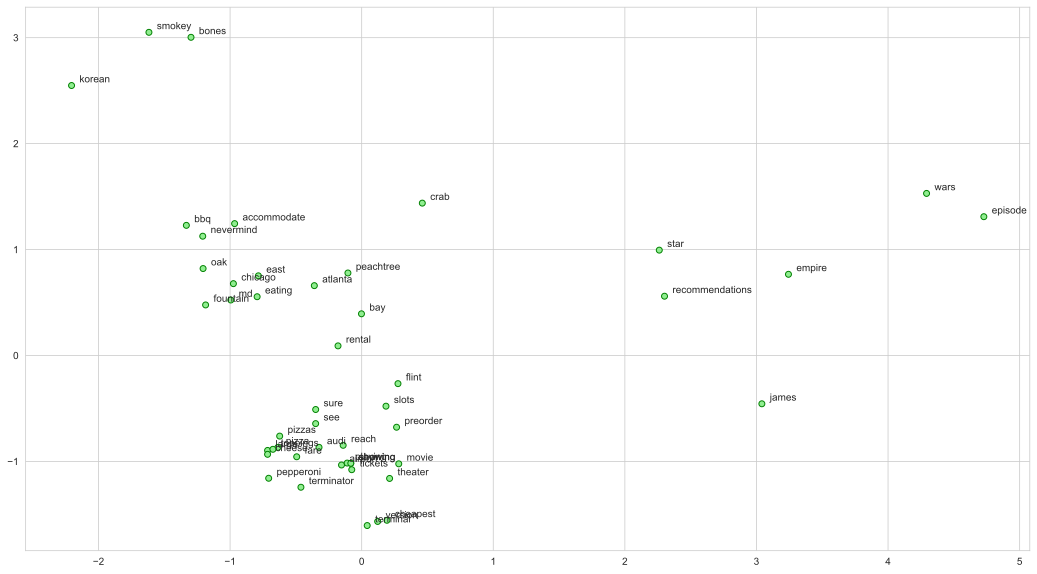

In [86]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [87]:
print(P.shape)

(48, 2)


In [88]:
ft_model.wv['rental']

array([ 0.0241013 ,  0.5514036 , -0.3219385 , -0.2648617 , -0.04602249,
       -0.34031108,  0.5641224 , -0.21108048, -0.08075743, -0.0109725 ,
       -0.00502517,  0.04491462, -0.1728986 , -0.42822465, -0.0088656 ,
       -0.51874316, -0.21864651,  0.0750889 , -0.34762612,  0.364915  ,
        0.49147034,  0.02305164, -0.13095933,  0.18851128, -0.2244338 ,
       -0.5234089 ,  0.05370995, -0.11401162, -0.251953  ,  0.2897131 ,
        0.09342602, -0.16830233, -0.58022636, -0.14534485,  0.0080693 ,
       -0.09258713, -0.01531859,  0.4601806 ,  0.04919064, -0.3536588 ,
        0.56061864, -0.16849309,  0.19979657, -0.30061695, -0.01737676,
        0.5004414 ,  0.03777344,  0.24916394,  0.6011719 , -0.01385436,
        0.00111656,  0.18173237,  0.2819084 ,  0.15929195, -0.04804542,
       -0.20305453, -0.31940523, -0.04715878,  0.2171904 ,  0.0556618 ,
        0.22171205, -0.17151721,  0.04306497, -0.19838493, -0.05204682,
        0.12565942, -0.31978366, -0.13300914,  0.40066415, -0.00

In [89]:
print(ft_model.wv.similarity(w1='pizza', w2='born'))
print(ft_model.wv.similarity(w1='playing', w2='movie'))

0.26553178
0.765427


In [90]:
st1 = "'tickets movie showing john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "pepperoni pizzas cheese pies"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ 'tickets movie showing john ]: 'tickets
Odd one out for [ pepperoni pizzas cheese pies ]: pies


## WOrd2Vec Features from Fastext Benchmarking with Naive Bayes Model

In [91]:
w2v_ft_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=ft_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.06,0.63,-0.37,-0.28,0.96,-0.57,-1.15,0.87,1.05,-0.04,0.42,-0.13,-0.91,0.62,1.23,...,0.11,0.54,0.06,-0.11,0.53,0.13,-0.63,0.60,0.01,-0.61,0.48,-0.57,1.60,0.37,-0.24
1,0.30,0.81,0.03,-0.37,0.40,0.67,0.98,-0.40,-0.44,0.78,-0.04,-0.24,1.55,-0.15,0.03,...,0.40,-0.25,0.00,0.75,0.23,0.24,0.29,-0.14,0.35,0.18,-0.42,0.64,-1.33,0.25,0.75
2,0.47,-0.70,-0.22,-0.32,0.75,0.12,-0.31,0.38,0.73,0.72,-0.02,0.11,-0.32,0.13,0.77,...,-0.52,-0.19,-0.58,0.91,0.06,0.94,-0.15,-0.83,0.41,-0.03,-0.26,0.57,-0.28,-0.06,0.65
3,-0.51,0.63,0.02,0.18,1.23,-1.28,0.18,-0.01,0.22,0.43,0.52,-0.08,0.33,0.58,-0.20,...,-0.91,0.14,0.21,-0.23,-0.48,0.78,0.25,0.17,0.86,-0.77,0.12,-0.56,0.12,0.80,0.44
4,0.47,-0.28,-0.77,0.11,1.09,-0.42,-0.74,0.13,0.10,-0.25,0.14,-0.58,-0.45,0.29,-0.10,...,-0.82,0.13,-0.58,0.13,-0.15,0.73,0.78,-0.77,0.21,-0.38,-0.50,-0.04,-0.48,0.62,-0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.22,-0.53,-0.02,-0.84,0.75,-0.10,-0.09,0.42,0.75,0.77,-0.05,0.05,-0.27,-0.28,0.95,...,-0.55,-0.97,-1.11,0.82,0.29,1.15,-0.45,-0.50,1.02,-0.41,-0.13,0.51,0.07,-0.19,0.35
746,-0.27,0.49,0.53,-0.05,0.66,-0.36,-0.31,0.10,0.99,-0.21,0.26,0.07,0.45,0.25,-0.09,...,-0.90,-0.26,-0.52,0.39,-0.58,-0.12,0.26,0.22,0.22,-0.34,-0.50,0.26,-0.39,0.85,0.10
747,0.38,0.03,0.09,-0.97,1.29,0.14,-0.44,0.31,0.40,0.98,-0.16,-0.02,0.28,0.30,0.02,...,-0.69,-0.29,-0.25,1.09,0.29,1.24,-0.31,-0.87,0.52,-0.32,-0.22,0.42,-0.61,-0.32,0.74
748,-0.11,0.40,-0.85,-0.70,0.70,-1.23,-0.41,0.07,0.57,-0.05,-0.00,-0.84,-0.25,0.45,-0.30,...,-0.45,0.05,-0.31,0.65,0.21,0.48,-0.01,-0.63,0.98,-0.67,-0.20,-0.30,0.10,0.77,-0.55


In [92]:
w2v_ft_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=ft_model,
                                             num_features=feature_size)

In [93]:
model_ft_nb = GaussianNB()
cm_nb_ft, pred_nb_ft, f1_nb_ft, report_nb_ft, accuracy_nb_ft  = SelectBestModelFeatures_Chi(model_ft_nb, 100, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Fastext Naive Bayes All Features", f1_nb_ft, accuracy_nb_ft])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.68,0.70
1,BOW Naive Bayes Optimal Features Selected: 1051,0.74,0.74
2,Bag of N-Gram Naive Bayes All Features,0.66,0.66
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,TF-IDF Naive Bayes All Features,0.54,0.60
5,TF-IDF Naive Bayes Optimal Features Selected: 330,0.58,0.62
6,Word2Vec Naive Bayes All Features,0.72,0.72
7,Word2Vec Naive Bayes Optimal Features Selected: 72,0.73,0.73
8,Word2Vec Fastext Naive Bayes All Features,0.56,0.60


## Word2Vec from Fastext Model Feature Selction with Naive Bayes Model

In [94]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_ft_nb, i, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_ft_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

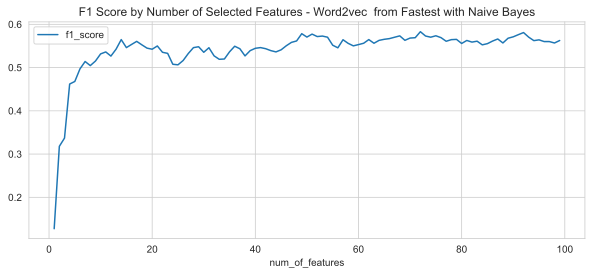

In [95]:
sel_nb_ft_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec  from Fastest with Naive Bayes", figsize=(10, 4))

In [96]:
Opt_no_of_feat = int(sel_nb_ft_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_ft_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
71,72,0.58,0.61
91,92,0.58,0.61
48,49,0.58,0.61
50,51,0.58,0.61
90,91,0.58,0.61


## Benchmarking Word2Vec Fastext with Naive Bayes on Optimal number of Features

In [97]:
cm_nb_ft, pred_nb_ft, f1_nb_ft, report_nb_ft, accuracy_nb_ft  = SelectBestModelFeatures_Chi(model_ft_nb, Opt_no_of_feat, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec from Fastest Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_nb_ft, accuracy_nb_ft])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.68,0.70
1,BOW Naive Bayes Optimal Features Selected: 1051,0.74,0.74
2,Bag of N-Gram Naive Bayes All Features,0.66,0.66
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,TF-IDF Naive Bayes All Features,0.54,0.60
5,TF-IDF Naive Bayes Optimal Features Selected: 330,0.58,0.62
6,Word2Vec Naive Bayes All Features,0.72,0.72
7,Word2Vec Naive Bayes Optimal Features Selected: 72,0.73,0.73
8,Word2Vec Fastext Naive Bayes All Features,0.56,0.60
9,Word2Vec from Fastest Naive Bayes Optimal Features Selected: 72,0.58,0.61


## Feature Extraction: Glove Word Embeddings

#### GloVe Embeddings with spaCy

In [98]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


#### Visualize GloVe word embeddings

In [99]:
unique_words = list(set([word for sublist in [doc.split() for doc in X_train] for word in sublist]))
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
availabe,0.27,-0.43,0.01,-0.29,-0.09,-0.38,0.42,-0.02,-0.11,-0.42,0.43,0.34,-0.12,0.00,0.47,...,0.08,0.08,-0.26,-0.30,-0.22,-0.17,-0.57,-0.06,-0.36,0.49,0.10,-0.16,-0.55,-0.17,0.30
foods,-0.56,0.07,-0.01,-0.14,0.11,1.26,-0.17,0.12,-0.34,1.81,-1.06,0.32,-0.17,0.14,0.21,...,0.75,0.49,-0.33,0.15,0.19,0.30,0.39,-0.54,-0.13,-0.38,0.24,-0.05,-0.83,0.68,0.01
times,-0.04,0.37,-0.30,-0.61,-0.31,0.11,-0.43,0.17,0.47,2.36,-0.04,0.21,0.01,-0.36,-0.50,...,-0.05,0.27,-0.51,0.24,0.50,-0.36,-0.06,-0.05,0.02,0.28,0.30,-0.14,0.02,0.24,0.00
gotcha,-0.29,-0.30,0.34,-0.25,0.02,0.18,-0.13,-0.22,-0.23,-0.06,0.06,-0.44,0.31,0.01,-0.44,...,-0.09,-0.05,-0.25,-0.21,0.61,0.23,0.12,-0.42,-0.10,0.70,-0.29,-0.48,-0.04,0.02,-0.06
rewatching,0.39,-0.41,-0.91,-0.26,-0.28,0.54,-0.04,0.41,0.01,-0.39,0.02,0.03,0.22,-0.18,0.10,...,0.12,0.58,-0.38,-0.36,-0.31,0.30,0.06,-0.74,-0.19,0.35,-0.02,-0.21,0.03,-0.51,-0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wheel,0.51,0.72,0.04,-0.68,-0.07,0.08,0.11,-0.17,-0.99,0.65,0.43,0.39,-0.48,0.16,-0.23,...,-0.37,-0.68,-0.12,0.14,-0.21,-0.63,-0.53,0.16,-0.30,-0.20,-0.04,0.29,0.40,0.01,0.12
seeing,0.01,0.12,-0.58,-0.14,0.36,0.12,-0.06,0.21,-0.19,2.80,-0.01,-0.01,0.04,-0.19,-0.09,...,-0.08,0.36,-0.04,0.02,0.02,-0.45,0.11,0.05,0.14,-0.09,0.17,-0.28,0.10,0.18,0.18
automatically,0.01,-0.08,-0.31,0.21,-0.36,-0.08,-0.44,-0.45,-0.11,1.50,0.47,0.47,-0.37,-0.26,-0.45,...,-0.46,0.06,0.02,0.14,-0.51,-0.20,0.17,0.06,0.38,-0.02,-0.59,-0.54,-0.12,0.39,0.11
dine,0.54,-0.60,0.46,-0.50,0.05,0.34,0.40,-0.26,-0.12,1.41,-0.55,0.08,-0.10,0.05,-0.07,...,0.21,0.56,0.33,-0.13,0.69,0.51,0.10,-0.77,0.07,0.26,0.01,0.52,-0.01,0.41,-0.05


In [100]:
unique_words_test = list(set([word for sublist in [doc.split() for doc in X_test] for word in sublist]))
word_glove_vectors_test = np.array([nlp(word).vector for word in unique_words])
print(word_glove_vectors_test.shape)

(5091, 300)


#### GloVe Embeddings with Flair

In [101]:
from flair.embeddings import WordEmbeddings, DocumentRNNEmbeddings

glove_embedding = WordEmbeddings('glove')
document_embeddings = DocumentRNNEmbeddings([glove_embedding])

In [ ]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['pizza', 'terminator', 'star', 'east', 'korean','playing']}
similar_words

In [102]:
from flair.embeddings import Sentence

# create an example sentence
sentence = Sentence('The grass is green . And the sky is blue .')
# embed the sentence with our document embedding
document_embeddings.embed(sentence)
# now check out the embedded sentence.
print(sentence.get_embedding())

tensor([ 1.4436e-01,  4.7242e-01,  1.7002e-01,  3.5252e-02,  3.5560e-01,
        -1.7592e-01,  2.7757e-01, -3.3097e-01,  1.5027e-01, -2.7758e-01,
        -1.9820e-01,  1.7374e-01,  1.2392e-01, -2.7409e-03,  2.5012e-03,
        -1.9999e-01, -7.6929e-02, -3.3750e-01,  4.8218e-02,  2.2261e-01,
        -1.9369e-01, -1.4334e-01,  1.3359e-01, -1.9917e-01,  2.6822e-01,
         1.9960e-01, -2.6483e-02, -1.7843e-01,  1.8505e-01,  1.2060e-01,
         5.1738e-02, -2.5556e-01,  1.3337e-01, -3.4470e-01, -3.0745e-01,
        -4.2055e-02, -1.2293e-02, -2.5381e-01,  6.4024e-03, -8.9794e-02,
        -3.5326e-01, -5.5153e-02,  2.0626e-01, -4.4120e-02, -2.1284e-01,
         1.7883e-01,  1.2160e-01, -1.3917e-01,  2.0900e-02,  2.3148e-01,
         1.4996e-01,  1.0405e-01, -2.5165e-04, -1.4185e-01, -1.4249e-01,
        -2.0309e-01,  8.1783e-02,  1.8820e-02,  8.3186e-02, -4.6699e-02,
         5.5659e-02, -1.5005e-01, -1.1024e-02, -1.4777e-02,  7.3348e-02,
        -1.8595e-01, -3.7914e-01,  6.5295e-02,  3.3

In [210]:
from nltk.tokenize import word_tokenize

def Get_Glove_Features(corpus):
    dataset_size = len(corpus)
    X = np.zeros((dataset_size, 128))
    for iter in range(0, dataset_size - 1):
        text = corpus[iter]
        sentence = Sentence(text)
        document_embeddings.embed(sentence)
        X[iter] = sentence.get_embedding().detach().numpy()
    return X

In [211]:
x_train_glove = Get_Glove_Features(X_train)
x_test_glove = Get_Glove_Features(X_test)
print(x_train_glove.shape, x_test_glove.shape)

(750, 128) (250, 128)


In [212]:
pd.DataFrame(x_train_glove)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.02,-0.09,0.07,0.01,0.35,-0.24,-0.11,-0.01,0.01,0.08,-0.21,-0.00,-0.21,-0.02,-0.07,...,-0.18,0.35,-0.17,0.21,-0.14,-0.39,-0.09,0.12,-0.05,0.11,0.42,-0.17,0.23,-0.32,0.02
1,0.41,0.49,0.09,0.00,0.08,-0.29,-0.04,-0.27,0.22,0.14,-0.43,-0.24,0.04,0.19,0.34,...,-0.22,-0.14,0.01,-0.09,-0.04,-0.12,0.09,-0.37,0.30,-0.07,0.14,0.02,-0.07,-0.13,0.20
2,0.00,-0.11,0.20,-0.06,0.34,-0.01,0.18,-0.24,-0.11,0.13,-0.15,0.22,-0.35,0.06,0.23,...,-0.24,0.25,-0.08,0.05,-0.12,-0.35,-0.15,-0.16,-0.03,0.40,0.38,-0.21,0.02,-0.29,0.04
3,0.35,0.27,0.02,0.07,0.04,-0.35,-0.09,-0.32,0.18,0.13,-0.31,-0.12,-0.18,0.06,0.44,...,-0.02,-0.07,0.03,0.06,0.02,-0.11,-0.15,-0.28,0.19,0.08,0.14,-0.05,0.06,-0.19,0.10
4,-0.15,0.07,0.14,0.07,0.30,-0.37,-0.13,-0.30,0.14,0.24,-0.20,0.16,-0.13,-0.17,0.22,...,-0.27,0.28,-0.44,0.12,-0.24,-0.25,-0.24,-0.19,0.11,0.46,0.48,-0.10,0.28,-0.09,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.20,0.17,0.07,0.21,0.15,-0.36,0.12,0.17,0.10,0.14,-0.16,0.12,-0.10,0.05,0.10,...,0.02,-0.03,0.01,0.00,-0.16,-0.20,0.03,-0.17,0.04,-0.08,0.15,-0.19,0.06,-0.06,-0.17
746,-0.07,-0.05,0.12,0.12,0.36,-0.21,0.11,-0.30,0.03,0.02,-0.18,0.22,-0.12,-0.01,0.18,...,-0.12,0.07,-0.10,0.09,-0.13,-0.38,-0.14,-0.02,0.05,0.27,0.18,-0.09,0.11,-0.20,-0.28
747,0.08,-0.04,0.16,0.33,-0.04,-0.29,0.05,-0.08,0.07,0.18,-0.13,0.08,-0.18,0.20,0.17,...,-0.19,0.02,-0.15,-0.09,-0.14,-0.34,-0.36,-0.35,0.09,0.05,0.16,-0.03,0.20,-0.11,0.01
748,-0.01,0.11,0.09,-0.37,0.32,0.02,0.05,-0.26,-0.07,-0.32,-0.30,-0.09,-0.27,-0.19,0.19,...,-0.21,0.09,-0.13,-0.17,0.23,-0.01,-0.17,-0.23,0.24,0.18,0.06,0.14,0.14,0.14,-0.04


In [213]:
model_glove_nb = GaussianNB()
cm_nb_glove, pred_nb_glove, f1_nb_glove, report_nb_glove, accuracy_nb_glove = Build_Model(model_glove_nb, x_train_glove, y_train, x_test_glove, y_test)
# Save benchmark output
# rows_benchmarks.append(["Glove with Naive Bayes All Features", f1_nb_glove, accuracy_nb_glove])
# df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
# df_benchmarks

## Feature Selection on Glove Features with Naive Bayes Model

In [214]:
rows = []
for i in range(1, 128, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_glove_nb, i, x_train_glove, y_train, x_test_glove, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_glove_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

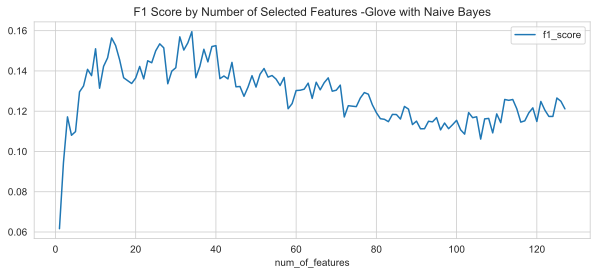

In [215]:
sel_nb_glove_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -Glove with Naive Bayes", figsize=(10, 4))

In [130]:
Opt_no_of_feat = int(sel_nb_glove_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_glove_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
30,31,0.16,0.17
14,15,0.16,0.18
13,14,0.16,0.17
9,10,0.16,0.18
15,16,0.15,0.18


In [134]:
cm_nb_glove, pred_nb_glove, f1_nb_glove, report_nb_glove, accuracy_nb_glove  = SelectBestModelFeatures_Chi(model_glove_nb, Opt_no_of_feat, x_train_glove, y_train, x_test_glove, y_test)

# Save benchmark output
# rows_benchmarks.append(["Glove Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_nb_glove, accuracy_nb_glove])
# df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
# df_benchmarks

In [132]:
# cm_nb_glove

array([[ 1,  1,  1,  0,  0,  0,  1,  0,  0,  2,  0,  0,  0,  1],
       [ 3,  4,  4,  2,  5,  3,  0,  3,  5,  0,  3,  0,  0,  2],
       [ 0,  2,  1,  0,  0,  1,  0,  1,  1,  1,  0,  0,  0,  1],
       [ 4,  0,  1,  3,  1,  2,  2,  1,  0,  3,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  3,  5,  1,  0,  0,  0,  1,  1,  1,  0],
       [ 0,  0,  0,  2,  1,  1,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 4,  2,  1,  1,  1,  3,  9,  0,  0,  2,  0,  2,  1,  1],
       [ 0,  0,  1,  0,  0,  0,  0,  2,  0,  2,  0,  0,  1,  0],
       [ 2,  5,  1,  0,  2,  1,  1,  4, 10,  6,  5,  3,  2,  1],
       [ 0,  3,  1,  2,  2,  1,  0,  1,  1,  1,  2,  6,  0,  0],
       [ 0,  2,  1,  0,  3,  1,  1,  0,  2,  0,  2,  0,  2,  2],
       [ 2,  0,  4,  1,  0,  3,  8,  2,  4,  5,  3,  4,  5,  3],
       [ 2,  0,  0,  0,  0,  1,  1,  0,  0,  0,  1,  0,  2,  1],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int64)

In [133]:
# print("Label" + report_nb_glove)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       0.14      0.06      0.08        18
 coffee-ordering-1       0.12      0.21      0.15        19
 coffee-ordering-2       0.12      0.06      0.08        16
      movie-finder       0.17      0.27      0.21        11
   movie-tickets-1       0.25      0.15      0.19        20
   movie-tickets-2       0.20      0.05      0.07        22
   movie-tickets-3       0.33      0.38      0.35        24
  pizza-ordering-1       0.33      0.14      0.20        14
  pizza-ordering-2       0.23      0.43      0.30        23
restaurant-table-1       0.05      0.05      0.05        22
restaurant-table-2       0.12      0.12      0.12        17
restaurant-table-3       0.09      0.25      0.13        16
       uber-lyft-1       0.25      0.13      0.17        15
       uber-lyft-2       0.00      0.00      0.00        13

          accuracy                           0.17       250
         macro avg       0.17    

#### Leave the Glove Feature result out for now since it clearly is problematic

## Combining Features

## Combine BOW and BAG of nGrams

In [180]:
def Get_Combined_Features(feat_1, feat_2):
    row_size = len(feat_1)
    col_size_1 = np.size(feat_1, axis=1)
    col_size = np.size(feat_1, axis=1) + np.size(feat_2, axis=1)
    X = np.zeros((row_size, col_size))
    #rint(X.shape, col_size_1, np.size(feat_2, axis=1), col_size)
    for i in range(0, row_size - 1):
        for j in range(0, col_size_1 - 1):
            X[i, j] = feat_1[i, j]

    for i in range(0, row_size - 1):
        for j in range(col_size_1, col_size - 1):
            X[i, j] = feat_2[i, j - col_size_1]
    return X

In [181]:
from numpy import column_stack

x_train_bow_bong = Get_Combined_Features(X_train_bow, X_train_bong)
x_test_bow_bong = Get_Combined_Features(X_test_bow, X_test_bong)

In [182]:
print(x_train_bow_bong.shape)
print(x_test_bow_bong.shape)

(750, 43008)
(250, 43008)


In [183]:
pd.DataFrame(x_test_bow_bong)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,42993,42994,42995,42996,42997,42998,42999,43000,43001,43002,43003,43004,43005,43006,43007
0,0.00,1.00,1.00,4.00,0.00,1.00,0.00,1.00,0.00,2.00,0.00,1.00,2.00,2.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,3.00,0.00,0.00,3.00,0.00,4.00,0.00,1.00,0.00,4.00,0.00,2.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,3.00,4.00,2.00,0.00,1.00,0.00,1.00,3.00,1.00,2.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,2.00,0.00,0.00,5.00,0.00,3.00,0.00,0.00,0.00,2.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,1.00,0.00,0.00,0.00,1.00,0.00,3.00,2.00,1.00,0.00,0.00,0.00,2.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.00,3.00,2.00,0.00,9.00,0.00,0.00,2.00,4.00,2.00,2.00,1.00,0.00,0.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
246,0.00,9.00,8.00,0.00,0.00,2.00,0.00,0.00,5.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
247,0.00,0.00,0.00,6.00,0.00,3.00,2.00,1.00,0.00,1.00,0.00,1.00,2.00,3.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
248,0.00,0.00,1.00,15.00,0.00,1.00,4.00,7.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [184]:
model_bow_bong = MultinomialNB()#.fit(X_train_tfidf, y_train)

cm_nb_bow_bong, pred_nb_bow_bong, f1_nb_bow_bong, report_bow_nb_bong, accuracy_bow_nb_bong = Build_Model(model_bow_bong, x_train_bow_bong, y_train, x_test_bow_bong, y_test)

In [185]:
print("Label" + report_bow_nb_bong)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       1.00      0.11      0.19        19
 coffee-ordering-2       0.48      1.00      0.65        16
      movie-finder       1.00      0.73      0.84        11
   movie-tickets-1       0.61      0.85      0.71        20
   movie-tickets-2       0.67      0.45      0.54        22
   movie-tickets-3       0.88      0.96      0.92        24
  pizza-ordering-1       0.47      0.64      0.55        14
  pizza-ordering-2       0.72      0.57      0.63        23
restaurant-table-1       1.00      0.27      0.43        22
restaurant-table-2       0.40      1.00      0.58        17
restaurant-table-3       1.00      0.50      0.67        16
       uber-lyft-1       0.89      0.53      0.67        15
       uber-lyft-2       0.67      0.92      0.77        13

          accuracy                           0.67       250
         macro avg       0.77    

In [186]:
rows = []
for i in range(1000, 43000, 1000): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_bow_bong, i, x_train_bow_bong, y_train, x_test_bow_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb__bow_bong_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

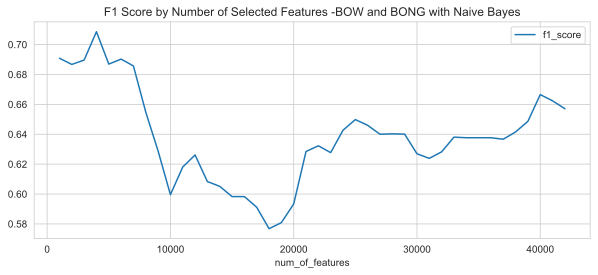

In [187]:
sel_nb__bow_bong_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -BOW and BONG with Naive Bayes", figsize=(10, 4))

In [188]:
Opt_no_of_feat = int(sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
3,4000,0.71,0.72
0,1000,0.69,0.70
5,6000,0.69,0.70
2,3000,0.69,0.70
4,5000,0.69,0.70


In [ ]:
rows = []
for i in range(1000, 43000, 1000): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_bow_bong, i, x_train_bow_bong, y_train, x_test_bow_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb__bow_bong_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

In [189]:
Opt_no_of_feat = int(sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).head(5)

3950 4050 1


,num_of_features,f1_score,accuracy
3,4000,0.71,0.72
0,1000,0.69,0.70
5,6000,0.69,0.70
2,3000,0.69,0.70
4,5000,0.69,0.70


In [190]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_bow_bong, Opt_no_of_feat, x_train_bow_bong, y_train, x_test_bow_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb__bow_bong_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

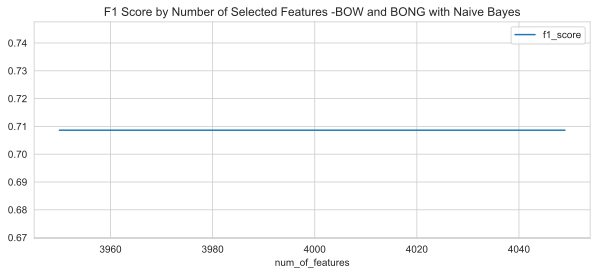

In [191]:
sel_nb__bow_bong_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -BOW and BONG with Naive Bayes", figsize=(10, 4))

In [195]:
# Save benchmark output
rows_benchmarks.append(["BOW + Bag of NGrams Top: " + str(Opt_no_of_feat) + " Features with Naive Bayes", f1_i, accuracy_i])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.68,0.70
1,BOW Naive Bayes Optimal Features Selected: 1051,0.74,0.74
2,Bag of N-Gram Naive Bayes All Features,0.66,0.66
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,TF-IDF Naive Bayes All Features,0.54,0.60
5,TF-IDF Naive Bayes Optimal Features Selected: 330,0.58,0.62
6,Word2Vec Naive Bayes All Features,0.72,0.72
7,Word2Vec Naive Bayes Optimal Features Selected: 72,0.73,0.73
8,Word2Vec Fastext Naive Bayes All Features,0.56,0.60
9,Word2Vec from Fastest Naive Bayes Optimal Features Selected: 72,0.58,0.61


In [ ]:
Combine BAG of nGrams and Word2Vec Features

## Feature Engineering, Extraction and Selection Final Results

#### Best results were produced from the BOW Features with optimal Features selected using a Naive Bayes Multinomial Model

#### Confusion Matrix Heat Map of the Predictions fron the Best Resulting Features

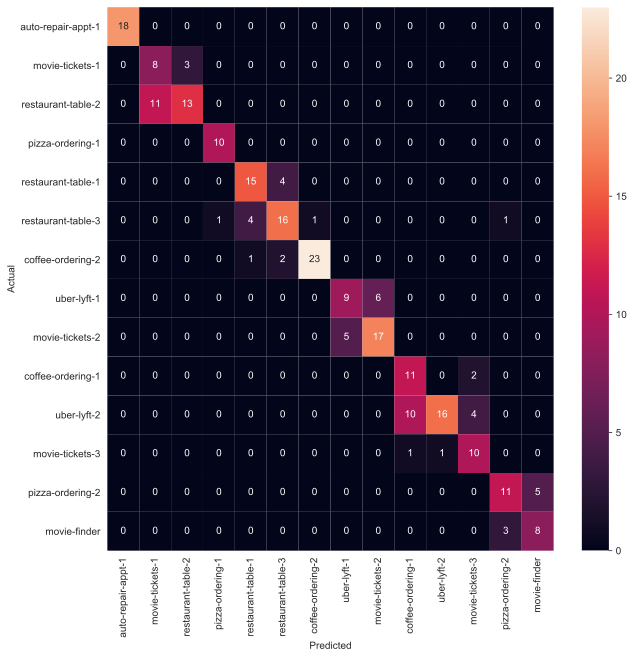

In [116]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_opt_bow, annot=True, fmt='d',
            xticklabels=category_id_df.Instruction_id.values, yticklabels=category_id_df.Instruction_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()